In [ ]:
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

from datetime import datetime
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

In [ ]:
%matplotlib inline

Questions we want to answer:
(1) NVDA, TSLA, and SP500 stock prices over time
(2) Distribution of the closing prices of these 3 (Which one has higher stock prices?)
(3) Is there any relationship between stock price and treasury bond yield?
(4) Is there an correlation between NVDA and TSLA stock prcies (as they are both in technology industry)
(5) Volatility of NVDA, TSLA, and SP500 stocks
(6) Relations between economics factors (interest rate, income level) and stock price

#Conlusion



*   Tsla has a high stock price and appears to be more volatile


*   Trends for stock price don't show significant correlation with 10-year treasury yield.

*   When interest rate decreases, the stocks' and index's price increase; When income level decreases, the stocks' and index's price also decrease.






# Import Data

We used API (https://www.tiingo.com/products/end-of-day-stock-price-data)to get NVDA and TSLA stock data, and SP500 stock data. The data we get from API is well structured as you can see. What we do is to check the integrity and the time range of the data, then align them to ensure all three tickets have data in that period.

In [ ]:
#use api to retrieve data
#https://www.tiingo.com/products/end-of-day-stock-price-data
if __name__ == "__main__":
  headers = {
    'Content-Type': 'application/json'
}
  r = requests.get("https://api.tiingo.com/tiingo/daily/nvda/prices?startDate=2000-01-01&endDate=2024-12-01&token=7ee6dfb7535b218689f77f8404c2fb583c33bb71", headers=headers)
  NVDA = r.json()


  r = requests.get("https://api.tiingo.com/tiingo/daily/tsla/prices?startDate=2000-01-01&endDate=2024-12-01&token=7ee6dfb7535b218689f77f8404c2fb583c33bb71", headers=headers)
  TSLA = r.json()

  r = requests.get("https://api.tiingo.com/tiingo/daily/SPY/prices?startDate=2000-01-01&endDate=2024-12-01&token=7ee6dfb7535b218689f77f8404c2fb583c33bb71", headers=headers)
  SP500 = r.json()

  def daily_price_parse_helper(json_data,filename):
      # data = json_data
      df = pd.DataFrame.from_records(json_data)
      df['date'] = pd.to_datetime(df['date'])
      df = df.sort_values(by='date')
      df.to_csv(filename, index=False)



  daily_price_parse_helper(NVDA,"NVDA_daily_prices_with_adjusted.csv")
  daily_price_parse_helper(TSLA,"TSLA_daily_prices_with_adjusted.csv")
  daily_price_parse_helper(SP500,"SP500_daily_prices_with_adjusted.csv")



In [ ]:
nvda = pd.read_csv("NVDA_daily_prices_with_adjusted.csv",index_col='date', parse_dates=True)
nvda.index = nvda.index.date
tsla = pd.read_csv("TSLA_daily_prices_with_adjusted.csv",index_col='date', parse_dates=True)
tsla.index = tsla.index.date
sp500 = pd.read_csv("SP500_daily_prices_with_adjusted.csv",index_col='date', parse_dates=True)
sp500.index = sp500.index.date

# Data Manipulation

In [ ]:
display(nvda.head())
display(nvda.describe())
display(nvda.info())

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2000-01-03,46.81,47.63,45.25,47.25,626900,0.089444,0.091011,0.086464,0.090285,300911849,0.0,1.0
2000-01-04,45.56,46.13,43.25,46.00,626000,0.087056,0.088145,0.082642,0.087897,300479849,0.0,1.0
2000-01-05,44.19,45.00,43.75,44.25,392400,0.084438,0.085986,0.083597,0.084553,188351905,0.0,1.0
2000-01-06,41.19,44.06,39.50,44.06,251000,0.078706,0.084190,0.075477,0.084190,120479939,0.0,1.0
2000-01-07,41.88,42.31,40.38,41.00,148300,0.080024,0.080846,0.077158,0.078343,71183964,0.0,1.0


,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,6268.000000,6268.000000,6268.000000,6268.00000,6.268000e+03,6268.000000,6268.000000,6268.000000,6268.000000,6.268000e+03,6268.000000,6268.000000
mean,114.278193,116.365587,111.995246,114.22860,2.109496e+07,8.073763,8.221723,7.912259,8.074114,6.138475e+08,0.000779,1.002473
std,168.372487,171.060758,165.221639,168.27462,4.359283e+07,21.550528,21.954611,21.115940,21.569360,4.288046e+08,0.009812,0.121957
min,5.900000,6.380000,5.750000,6.00000,1.483000e+05,0.056330,0.060290,0.055031,0.055795,4.564512e+07,0.000000,1.000000
25%,17.117500,17.457500,16.800000,17.08000,6.425668e+06,0.274696,0.280658,0.269652,0.275843,3.544668e+08,0.000000,1.000000
50%,32.835000,33.520000,32.265000,32.97000,1.066728e+07,0.446716,0.453379,0.439263,0.445831,5.126606e+08,0.000000,1.000000
75%,157.345000,160.347475,154.037500,157.76750,1.878238e+07,4.718674,4.775197,4.643522,4.723298,7.393769e+08,0.000000,1.000000
max,1224.400000,1255.870000,1183.200000,1240.48000,6.554847e+08,148.869737,152.879461,146.249918,149.339705,9.230851e+09,0.160000,10.000000


<class 'pandas.core.frame.DataFrame'>
Index: 6268 entries, 2000-01-03 to 2024-11-29
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        6268 non-null   float64
 1   high         6268 non-null   float64
 2   low          6268 non-null   float64
 3   open         6268 non-null   float64
 4   volume       6268 non-null   int64  
 5   adjClose     6268 non-null   float64
 6   adjHigh      6268 non-null   float64
 7   adjLow       6268 non-null   float64
 8   adjOpen      6268 non-null   float64
 9   adjVolume    6268 non-null   int64  
 10  divCash      6268 non-null   float64
 11  splitFactor  6268 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 636.6+ KB


None

In [ ]:
display(tsla.head())
display(tsla.describe())
display(tsla.info())

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2010-06-29,23.89,25.0000,17.54,19.00,18766300,1.592667,1.666667,1.169333,1.266667,281494500,0.0,1.0
2010-06-30,23.83,30.4192,23.30,25.79,17187100,1.588667,2.027947,1.553333,1.719333,257806500,0.0,1.0
2010-07-01,21.96,25.9200,20.27,25.00,8218800,1.464000,1.728000,1.351333,1.666667,123282000,0.0,1.0
2010-07-02,19.20,23.1000,18.71,23.00,5139800,1.280000,1.540000,1.247333,1.533333,77097000,0.0,1.0
2010-07-06,16.11,20.0000,15.83,20.00,6866900,1.074000,1.333333,1.055333,1.333333,103003500,0.0,1.0


,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,3631.000000,3631.000000,3631.000000,3631.000000,3.631000e+03,3631.000000,3631.000000,3631.000000,3631.000000,3.631000e+03,3631.0,3631.000000
mean,302.152801,308.655405,295.213341,302.093656,2.655611e+07,79.590246,81.350048,77.754704,79.609117,9.663672e+07,0.0,1.001652
std,283.533943,290.991802,275.366324,283.343843,4.261035e+07,104.836841,107.237135,102.377953,104.910804,7.792193e+07,0.0,0.074209
min,15.800000,16.630000,14.980000,16.140000,1.185000e+05,1.053333,1.108667,0.998667,1.076000,1.777500e+06,0.0,1.000000
25%,164.485000,168.195000,160.595000,164.117500,3.430144e+06,12.022333,12.317000,11.713333,11.995333,4.866678e+07,0.0,1.000000
50%,231.430000,235.500000,227.660000,231.500000,7.352082e+06,17.831333,18.066667,17.498667,17.798667,8.193069e+07,0.0,1.000000
75%,332.200000,337.880000,326.035000,332.225000,2.512368e+07,175.990000,179.460000,172.621200,175.400000,1.222555e+08,0.0,1.000000
max,2238.750000,2318.490000,2186.520000,2295.120000,3.065906e+08,409.970000,414.496667,405.666667,411.470000,9.140814e+08,0.0,5.000000


<class 'pandas.core.frame.DataFrame'>
Index: 3631 entries, 2010-06-29 to 2024-11-29
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        3631 non-null   float64
 1   high         3631 non-null   float64
 2   low          3631 non-null   float64
 3   open         3631 non-null   float64
 4   volume       3631 non-null   int64  
 5   adjClose     3631 non-null   float64
 6   adjHigh      3631 non-null   float64
 7   adjLow       3631 non-null   float64
 8   adjOpen      3631 non-null   float64
 9   adjVolume    3631 non-null   int64  
 10  divCash      3631 non-null   float64
 11  splitFactor  3631 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 368.8+ KB


None

In [ ]:
display(sp500.head())
display(sp500.describe())
display(sp500.info())

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
2000-01-03,145.4375,148.250000,143.875000,148.250000,8164300,92.925099,94.722103,91.926763,94.722103,8164300,0.0,1.0
2000-01-04,139.7500,144.062500,139.640594,143.531204,8089800,89.291156,92.046563,89.221253,91.707100,8089800,0.0,1.0
2000-01-05,140.0000,141.531204,137.250000,139.937500,12177900,89.450890,90.429230,87.693819,89.410957,12177900,0.0,1.0
2000-01-06,137.7500,141.500000,137.750000,139.625000,6227200,88.013286,90.409292,88.013286,89.211289,6227200,0.0,1.0
2000-01-07,145.7500,145.750000,140.062500,140.312500,8066500,93.124766,93.124766,89.490823,89.650557,8066500,0.0,1.0


,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,6268.000000,6268.000000,6268.000000,6268.000000,6.268000e+03,6268.000000,6268.000000,6268.000000,6268.000000,6.268000e+03,6268.000000,6268.0
mean,209.794516,211.001200,208.442591,209.779292,1.061845e+08,181.072918,182.096235,179.919336,181.055880,1.061845e+08,0.014248,1.0
std,121.990431,122.517879,121.344722,121.959728,9.099042e+07,130.294016,130.899057,129.567200,130.263725,9.099042e+07,0.125013,0.0
min,68.110001,70.000000,67.099998,67.949997,1.708170e+05,50.651700,52.057245,49.900586,50.532709,1.708170e+05,0.000000,1.0
25%,120.200000,120.975000,119.392501,120.194998,5.024115e+07,85.144816,85.704568,84.652575,85.226751,5.024115e+07,0.000000,1.0
50%,148.904999,149.775002,147.785004,148.879998,7.901170e+07,111.097303,111.561084,110.447787,110.916188,7.901170e+07,0.000000,1.0
75%,273.935000,275.262500,272.247500,273.687500,1.349850e+08,247.353359,249.011618,245.919161,247.265480,1.349850e+08,0.000000,1.0
max,602.550000,603.350000,599.380000,600.460000,8.710263e+08,602.550000,603.350000,599.380000,600.460000,8.710263e+08,1.906073,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 6268 entries, 2000-01-03 to 2024-11-29
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        6268 non-null   float64
 1   high         6268 non-null   float64
 2   low          6268 non-null   float64
 3   open         6268 non-null   float64
 4   volume       6268 non-null   int64  
 5   adjClose     6268 non-null   float64
 6   adjHigh      6268 non-null   float64
 7   adjLow       6268 non-null   float64
 8   adjOpen      6268 non-null   float64
 9   adjVolume    6268 non-null   int64  
 10  divCash      6268 non-null   float64
 11  splitFactor  6268 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 636.6+ KB


None

In [ ]:
# convert the index to timestamp
nvda.index = pd.to_datetime(nvda.index)
print(nvda.index.min(), nvda.index.max())
tsla.index = pd.to_datetime(tsla.index)
print(tsla.index.min(), tsla.index.max())
sp500.index = pd.to_datetime(sp500.index)
print(sp500.index.min(),sp500.index.max())

2000-01-03 00:00:00 2024-11-29 00:00:00
2010-06-29 00:00:00 2024-11-29 00:00:00
2000-01-03 00:00:00 2024-11-29 00:00:00


# Data Visualization

## Stock Prices Over Time

> 添加区块引用符号



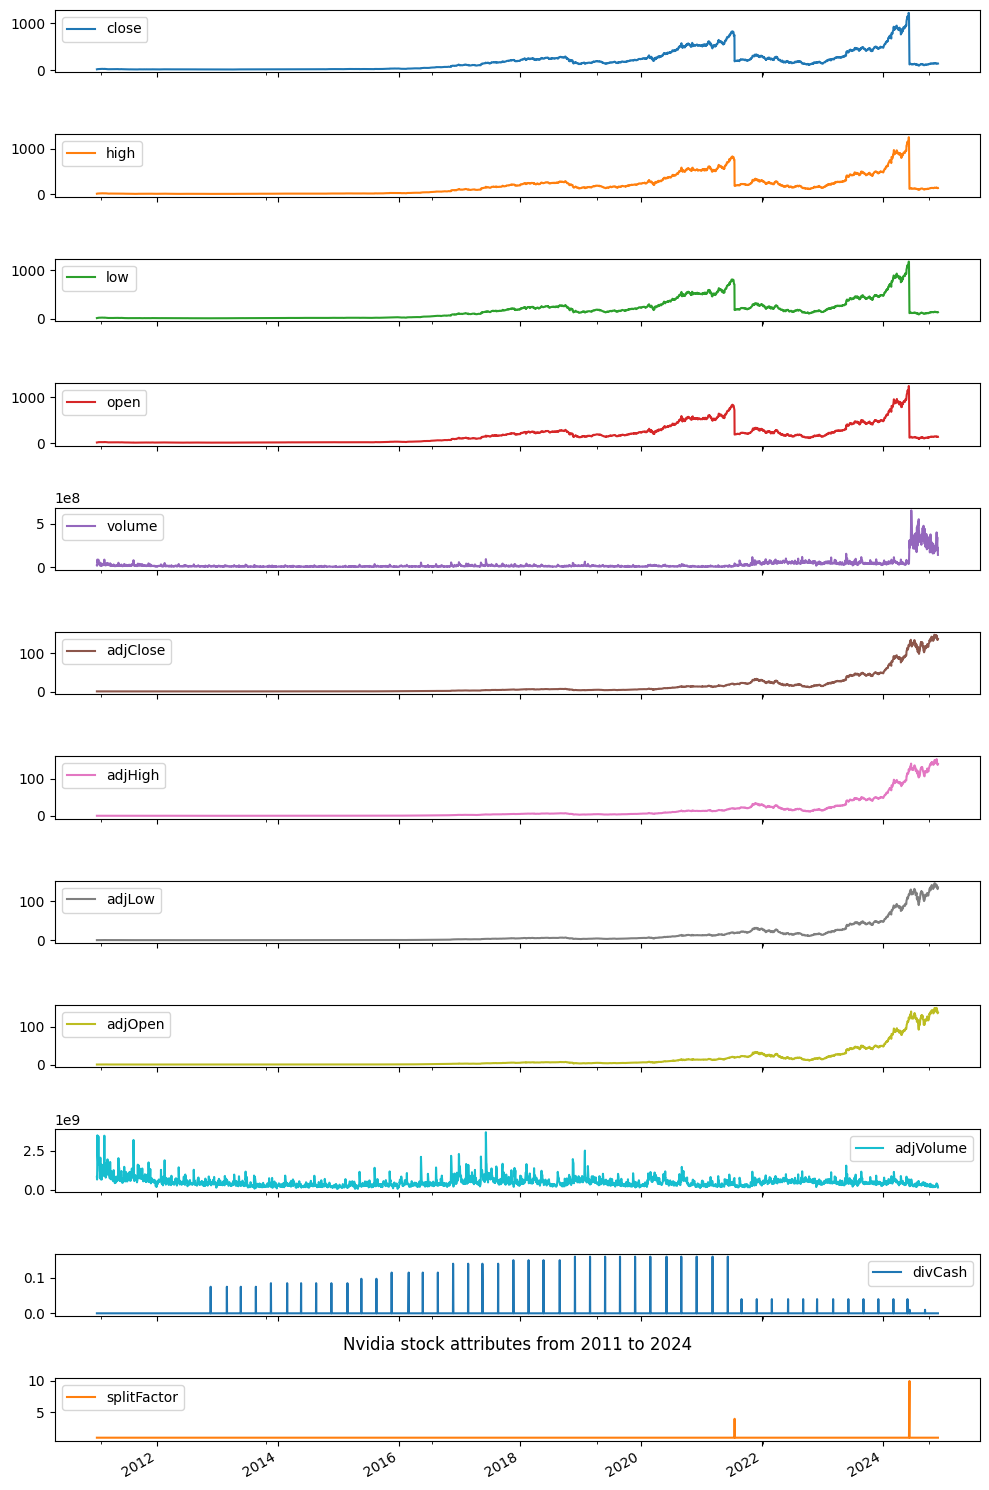

In [ ]:
# To have a brief impression on the data, we first draw the lines over time to see the overall trends.
nvda['2011':'2024'].plot(subplots=True, figsize=(10,15))
plt.title('Nvidia stock attributes from 2011 to 2024',pad=20)
plt.tight_layout()
plt.show()

# We can see that nvdia obviously has two stock splits over the past 13 years, which leads to the significant drop on the unadjusted price.
# So, we should use the adjusted close price to see the real trends.
# The stock price started to increase significantly from 2023, which is the year generative AI rose to prominence.

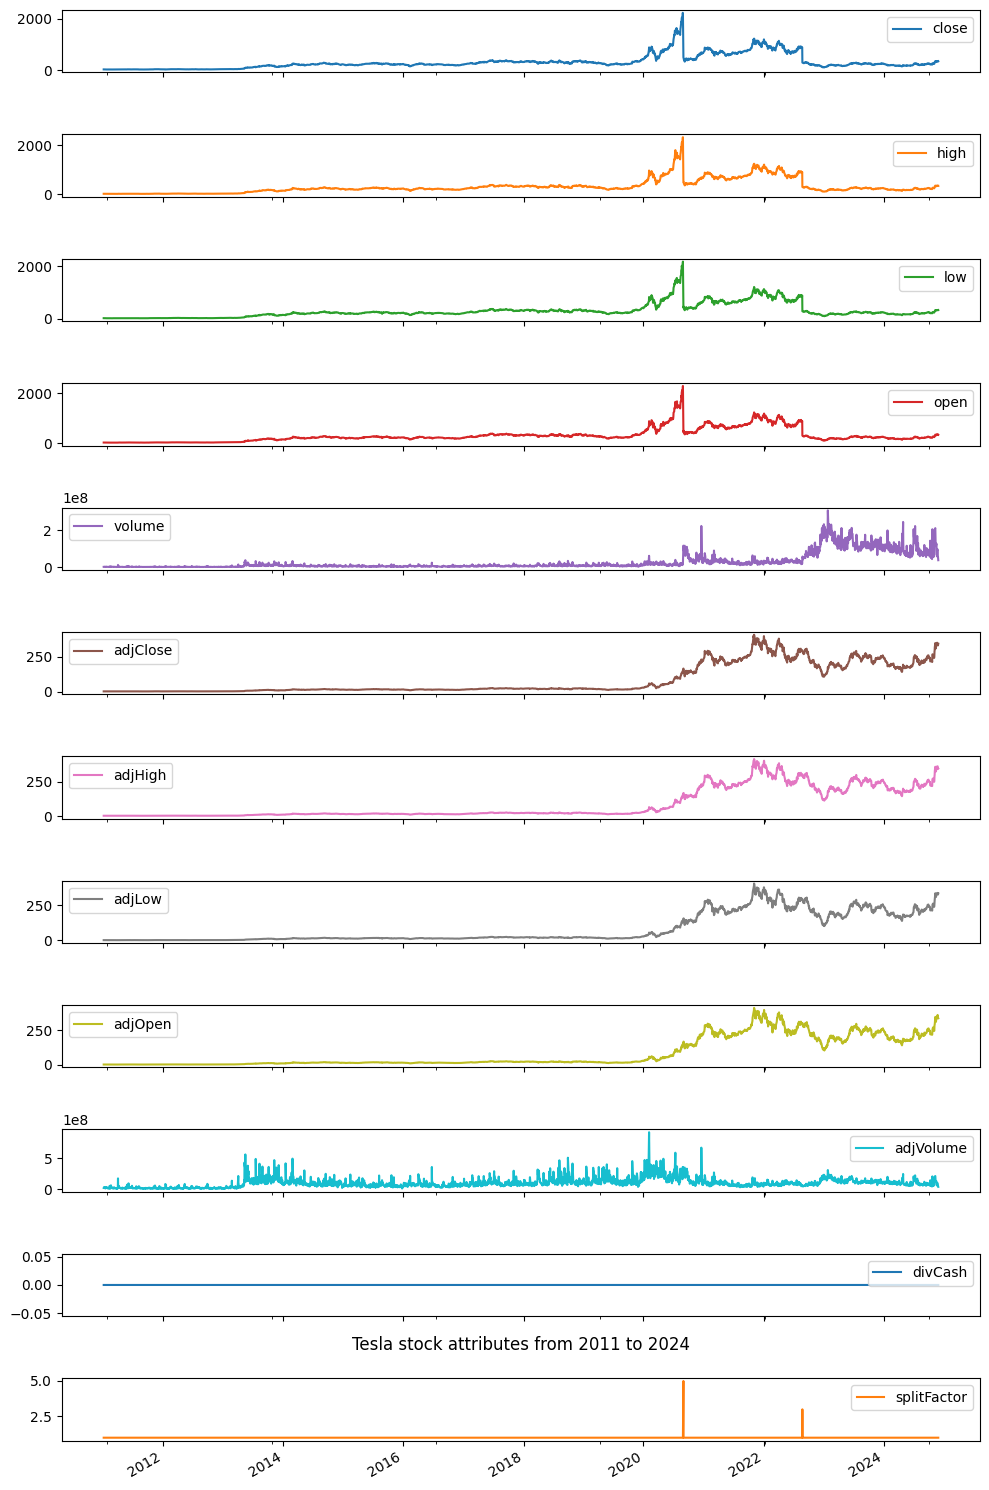

In [ ]:
tsla['2011':'2024'].plot(subplots=True, figsize=(10,15))
plt.title('Tesla stock attributes from 2011 to 2024',pad=20)
plt.tight_layout()
plt.show()
# We can see that tsla also has two stock splits over the past 13 years, which leads to the drop on the unadjusted price.
# So, we should use the adjusted close price to see the real trends.
# Overall, tesla has a higher stock price than nvidia.
# The stock price increased a lot in 2020 when tesla delievered its Model Y and had achieved three consecutive quarters of profitability.

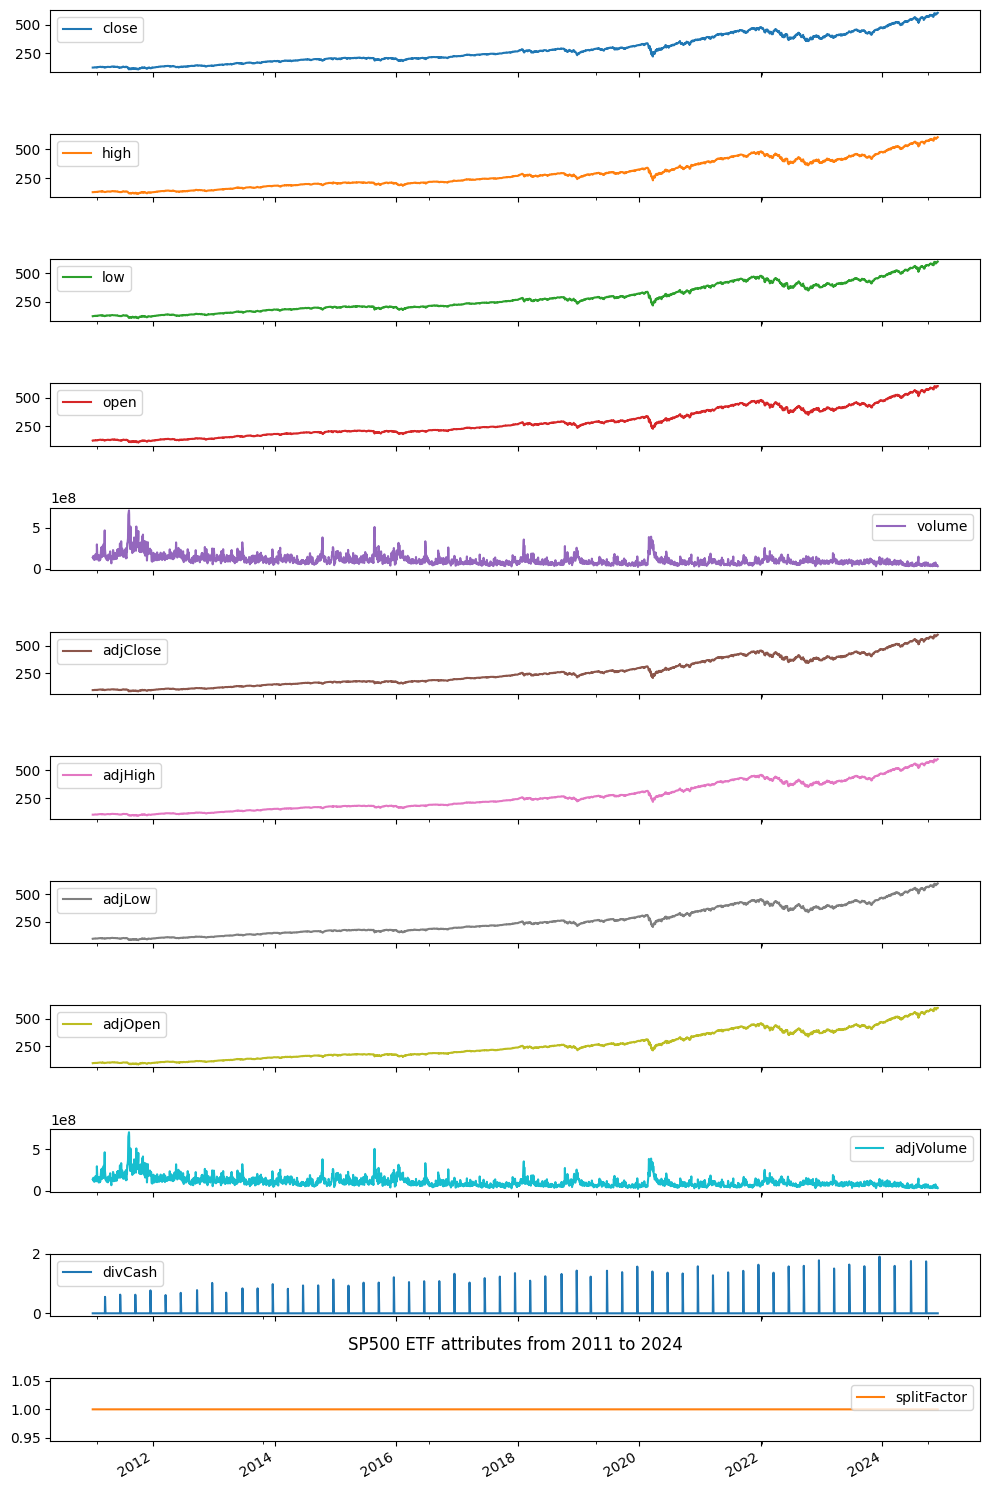

In [ ]:
sp500['2011':'2024'].plot(subplots=True, figsize=(10,15))
plt.title('SP500 ETF attributes from 2011 to 2024',pad=20)
plt.tight_layout()
plt.show()

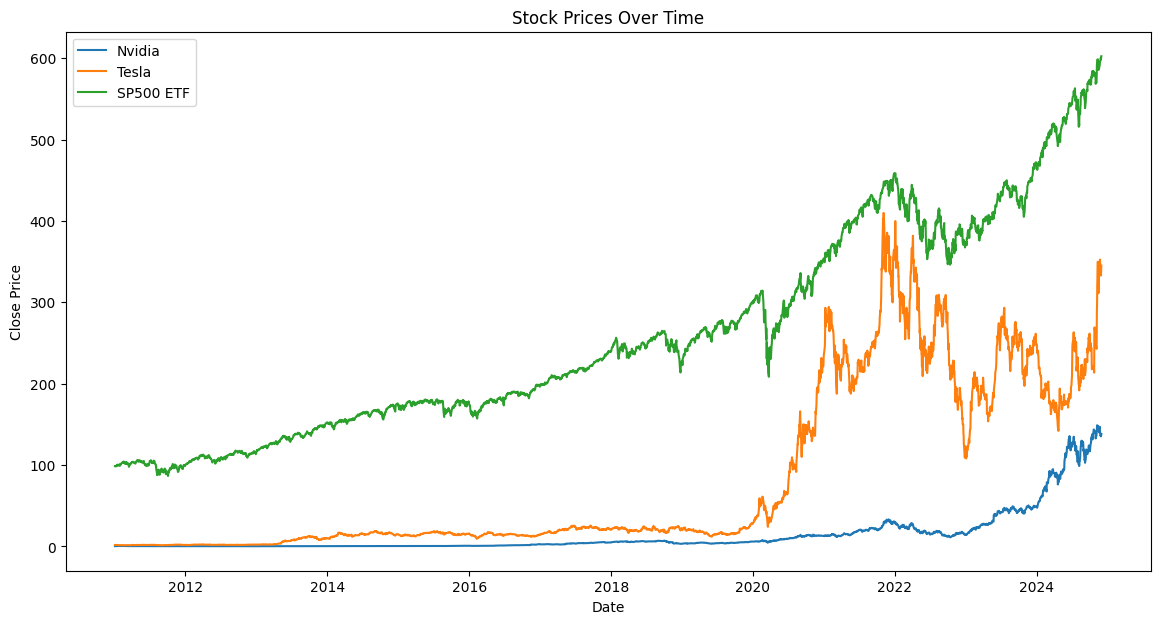

In [ ]:
# Compare the three in one graph.
start_date = '2011-01-01'
end_date = '2024-12-01'

plt.figure(figsize=(14, 7))
plt.plot(nvda[start_date: end_date].index, nvda.loc[start_date: end_date]['adjClose'], label='Nvidia')
plt.plot(tsla[start_date: end_date].index, tsla.loc[start_date: end_date]['adjClose'], label='Tesla')
plt.plot(sp500[start_date: end_date].index, sp500.loc[start_date: end_date]['adjClose'], label = 'SP500 ETF')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Distribution of Closing Prices

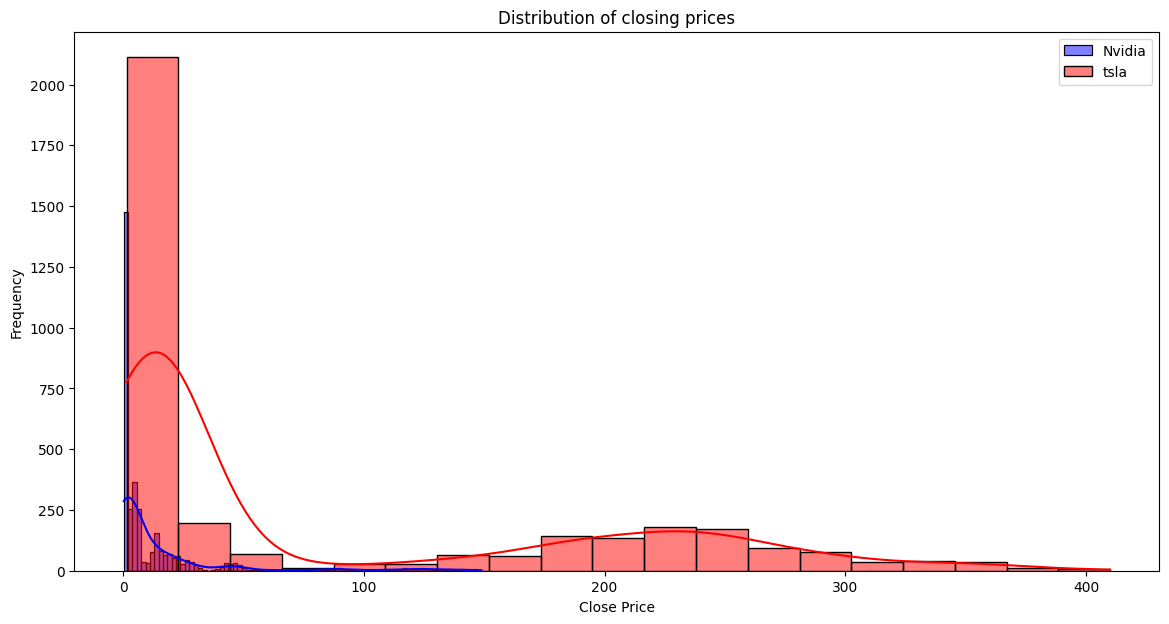

In [ ]:
# This histogram visualizes the distribution of closing prices
start_date = '2011-01-01'
end_date = '2024-12-01'
plt.figure(figsize=(14,7))
sns.histplot(nvda.loc[start_date: end_date]['adjClose'],kde = True, color='blue',label='Nvidia')
sns.histplot(tsla.loc[start_date: end_date]['adjClose'],kde = True, color='red',label='tsla')
plt.title('Distribution of closing prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()
# Overall, tsla has much higher stock prices.

## KDE Plot of Closing Prices

<ipython-input-14-95224a180cba>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nvda.loc[start_date: end_date]['adjClose'],shade = True, color = 'blue',label='Nvidia')
<ipython-input-14-95224a180cba>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tsla.loc[start_date: end_date]['adjClose'],shade = True, color = 'red', label='Tesla')
<ipython-input-14-95224a180cba>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sp500.loc[start_date: end_date]['adjClose'],shade = True, color = 'green', label='SP500 ETF')


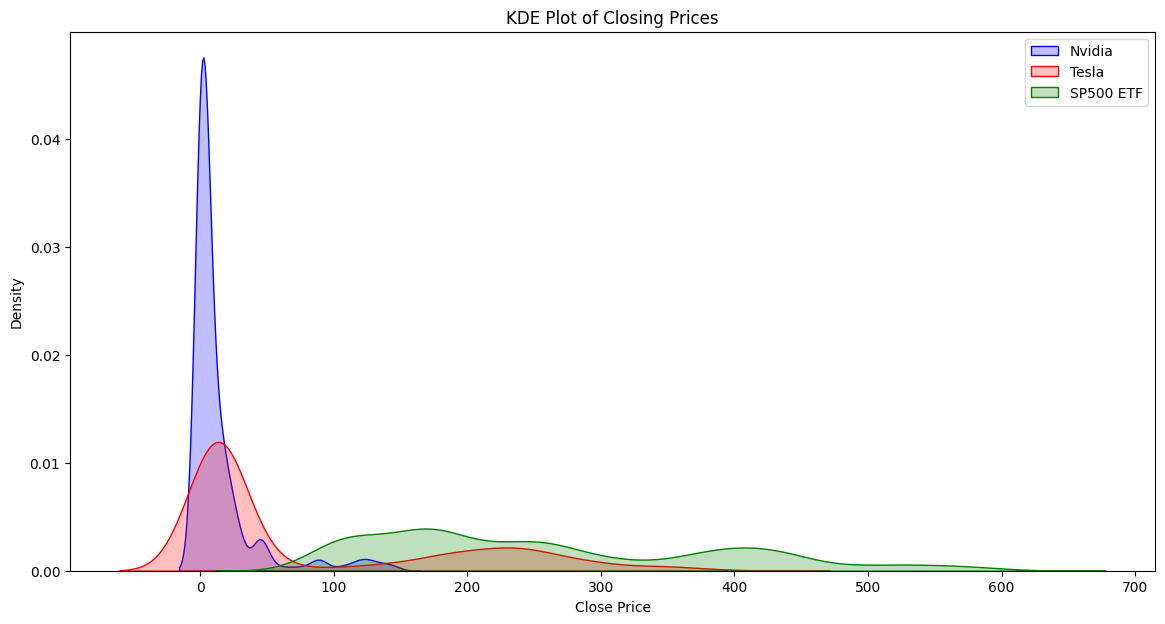

In [ ]:
# This KDE plot also visualizes the distribution of closing prices, highlighting the most frequent price ranges.
plt.figure(figsize=(14,7))
sns.kdeplot(nvda.loc[start_date: end_date]['adjClose'],shade = True, color = 'blue',label='Nvidia')
sns.kdeplot(tsla.loc[start_date: end_date]['adjClose'],shade = True, color = 'red', label='Tesla')
sns.kdeplot(sp500.loc[start_date: end_date]['adjClose'],shade = True, color = 'green', label='SP500 ETF')
plt.title('KDE Plot of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.legend()
plt.show()

## Volume Over Time

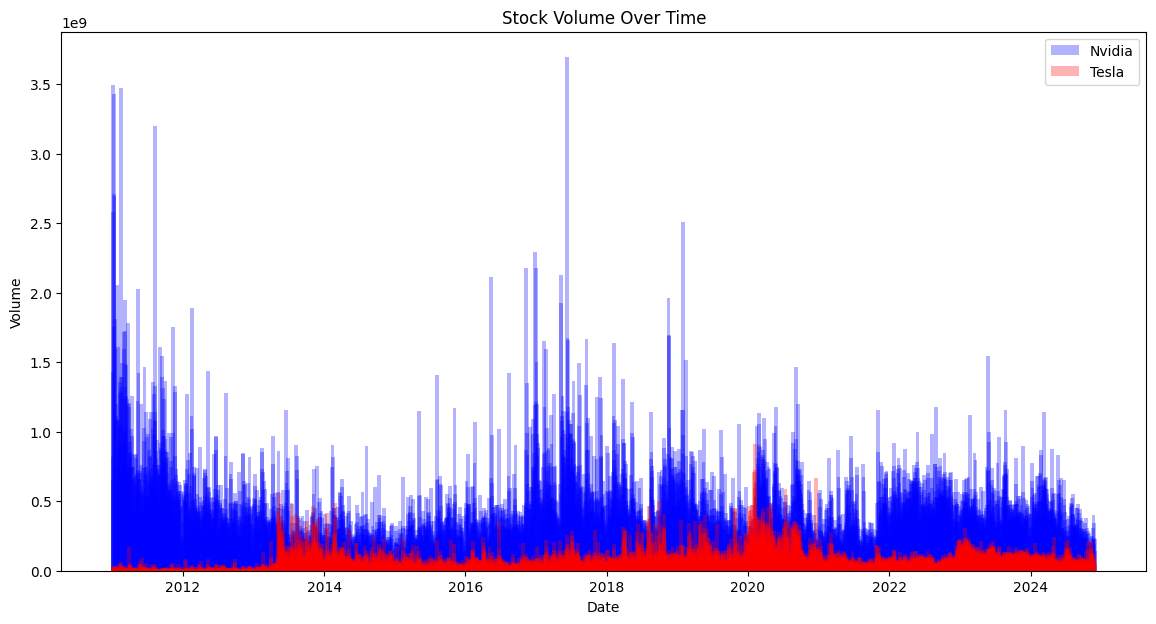

In [ ]:
# This line chart illustrates the trading volume trends over time, showing fluctuations in market activity.
plt.figure(figsize=(14, 7))
plt.bar(nvda[start_date: end_date].index, nvda.loc[start_date: end_date]['adjVolume'], label='Nvidia',color='blue',width=20,alpha=0.3)
plt.bar(tsla[start_date: end_date].index, tsla.loc[start_date: end_date]['adjVolume'], label='Tesla',color='red',width=20,alpha=0.3)
plt.title('Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

## Compare with treasury yield(10 Year)

In [ ]:
# Fetches 10-year Treasury yield data from Yahoo Finance.
import yfinance as yf
treasury_yield_data = yf.download('^TNX', start='2000-01-01', end='2024-12-01')
treasury_yield_data['Close'] = treasury_yield_data['Close'] / 100
treasury_yield_data = treasury_yield_data[['Close']]
treasury_yield_data.rename(columns={'Close': '10Y_Treasury_Yield'}, inplace=True)
treasury_yield_data.head()

[*********************100%***********************]  1 of 1 completed
<ipython-input-7-ecb40c5ee9d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasury_yield_data.rename(columns={'Close': '10Y_Treasury_Yield'}, inplace=True)


Price,10Y_Treasury_Yield
Ticker,^TNX
Date,
2000-01-03,0.06548
2000-01-04,0.06485
2000-01-05,0.06599
2000-01-06,0.06549
2000-01-07,0.06504


In [ ]:
# manipulate the stock and yield data, combine into one dataframe, and calculate the return by month
time_filter_tsla = tsla.index > datetime(2011,1,1)
time_filter_nvda = nvda.index > datetime(2011,1,1)
time_filter_sp500= sp500.index > datetime(2011,1,1)
time_filter_treasury= treasury_yield_data.index > datetime(2011,1,1)
tsla_filtered = tsla[time_filter_tsla]
nvda_filtered = nvda[time_filter_nvda]
sp500_filtered = sp500[time_filter_sp500]
treasury_filtered = treasury_yield_data[time_filter_treasury]
nvda_close = nvda_filtered.adjClose
tsla_close = tsla_filtered.adjClose
sp500_close = sp500_filtered.adjClose

treasury_filtered = treasury_filtered.squeeze()

combined = pd.DataFrame({
    'nvda': nvda_close,
    'tsla': tsla_close,
    'SP500': sp500_close,
    'Treasury_Yield': treasury_filtered
})
monthly_data = combined.resample('ME').last()

monthly_data['nvda_Return'] = monthly_data['nvda'].pct_change()
monthly_data['tsla_Return'] = monthly_data['tsla'].pct_change()
monthly_data['SP500_Return'] = monthly_data['SP500'].pct_change()
monthly_data.dropna(inplace=True)

In [ ]:
monthly_data.head()

,nvda,tsla,SP500,Treasury_Yield,nvda_Return,tsla_Return,SP500_Return
2011-02-28,0.519584,1.592667,103.314525,0.03414,-0.052676,-0.008714,0.034737
2011-03-31,0.423280,1.850000,103.325573,0.03454,-0.185349,0.161574,0.000107
2011-04-30,0.458591,1.840000,106.318032,0.03296,0.083424,-0.005405,0.028961
2011-05-31,0.459509,2.009333,105.125724,0.03050,0.002000,0.092029,-0.011215
2011-06-30,0.365383,1.942000,103.350451,0.03158,-0.204840,-0.033510,-0.016887


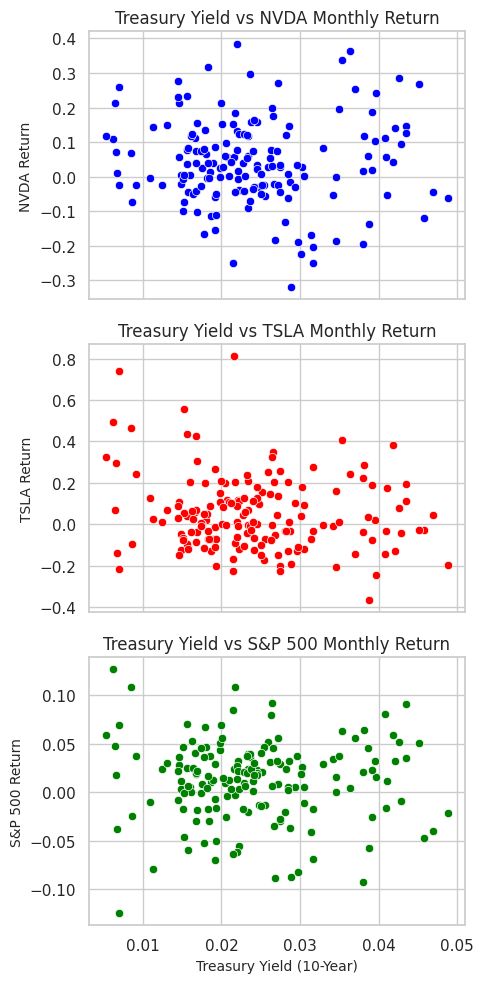

In [ ]:
# draw the scatter plt
sns.set(style='whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
sns.scatterplot(
    x=monthly_data['Treasury_Yield'],
    y=monthly_data['nvda_Return'],
    ax=axes[0], color='blue'
)
axes[0].set_title('Treasury Yield vs NVDA Monthly Return', fontsize=12)
axes[0].set_ylabel('NVDA Return', fontsize=10)

sns.scatterplot(
    x=monthly_data['Treasury_Yield'],
    y=monthly_data['tsla_Return'],
    ax=axes[1], color='red'
)
axes[1].set_title('Treasury Yield vs TSLA Monthly Return', fontsize=12)
axes[1].set_ylabel('TSLA Return', fontsize=10)

sns.scatterplot(
    x=monthly_data['Treasury_Yield'],
    y=monthly_data['SP500_Return'],
    ax=axes[2], color='green'
)
axes[2].set_title('Treasury Yield vs S&P 500 Monthly Return', fontsize=12)
axes[2].set_xlabel('Treasury Yield (10-Year)', fontsize=10)
axes[2].set_ylabel('S&P 500 Return', fontsize=10)

plt.tight_layout()
plt.show()
# It looks like treasury yield has no correlations with stock prices.

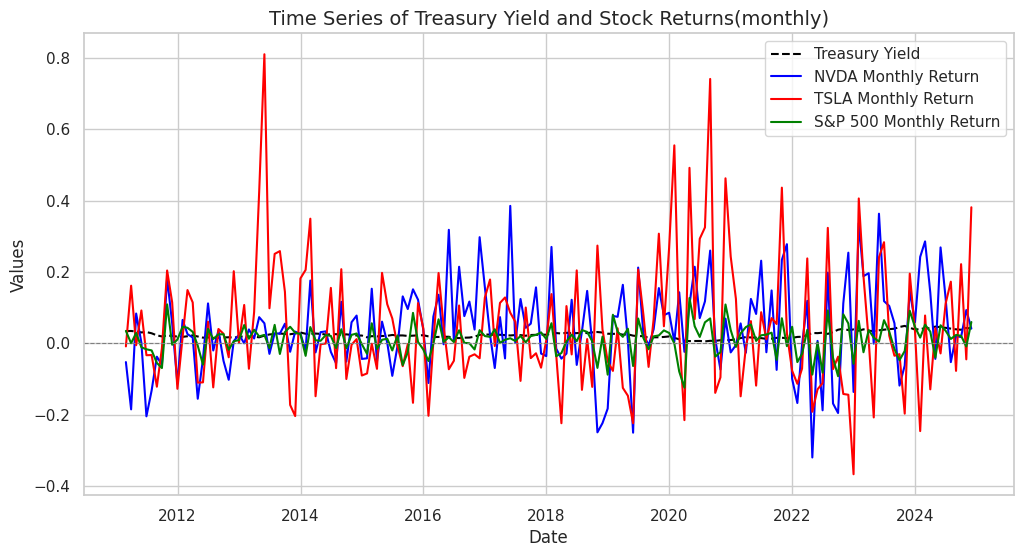

In [ ]:
# creates a time series plot comparing monthly Treasury yields with the monthly returns of NVDA, TSLA, and the S&P 500, using different colors and styles for clarity.
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Treasury_Yield'], label='Treasury Yield', color='black', linestyle='--')
plt.plot(monthly_data.index, monthly_data['nvda_Return'], label='NVDA Monthly Return', color='blue')
plt.plot(monthly_data.index, monthly_data['tsla_Return'], label='TSLA Monthly Return', color='red')
plt.plot(monthly_data.index, monthly_data['SP500_Return'], label='S&P 500 Monthly Return', color='green')

plt.title('Time Series of Treasury Yield and Stock Returns(monthly)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.show()
# returns: tsla > nvda > sp500 > treasury bond

In [ ]:
# category based on the yield, as Tightening or Easing period
def classify_trend(change):
    if change > 0.0025:
        return 'Tightening'
    elif change < -0.0025:
        return 'Easing'
    else:
        return 'Neutral'


monthly_data['Yield_Change'] = monthly_data['Treasury_Yield'].diff()
monthly_data['Trend_Category']=monthly_data['Yield_Change'].apply(classify_trend)
monthly_data['Yield_Change'].fillna(method='bfill', inplace=True)
print(monthly_data[['Treasury_Yield', 'Yield_Change', 'Trend_Category']].to_string())
monthly_data['Trend_Category'] = monthly_data['Trend_Category'].astype('category')

            Treasury_Yield  Yield_Change Trend_Category
2011-02-28         0.03414       0.00040        Neutral
2011-03-31         0.03454       0.00040        Neutral
2011-04-30         0.03296      -0.00158        Neutral
2011-05-31         0.03050      -0.00246        Neutral
2011-06-30         0.03158       0.00108        Neutral
2011-07-31         0.02805      -0.00353         Easing
2011-08-31         0.02218      -0.00587         Easing
2011-09-30         0.01924      -0.00294         Easing
2011-10-31         0.02175       0.00251     Tightening
2011-11-30         0.02068      -0.00107        Neutral
2011-12-31         0.01871      -0.00197        Neutral
2012-01-31         0.01799      -0.00072        Neutral
2012-02-29         0.01977       0.00178        Neutral
2012-03-31         0.02216       0.00239        Neutral
2012-04-30         0.01915      -0.00301         Easing
2012-05-31         0.01581      -0.00334         Easing
2012-06-30         0.01659       0.00078        

<ipython-input-9-31ce5cbd08ef>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_data['Yield_Change'].fillna(method='bfill', inplace=True)
<ipython-input-9-31ce5cbd08ef>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['Yield_Change'].fillna(method='bfill', inplace=True)


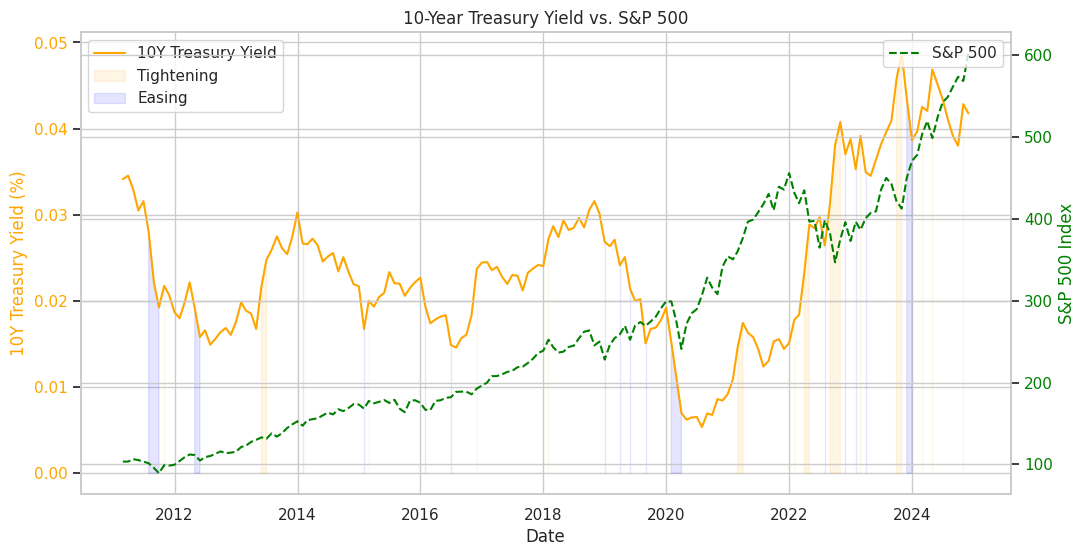

In [ ]:
# draw the line chart with Tightening or Easing period categories showned on it.
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(monthly_data.index, monthly_data['Treasury_Yield'], label='10Y Treasury Yield',color='orange')
ax1.fill_between(
    monthly_data.index,
    monthly_data['Treasury_Yield'],
    color='orange',
    alpha=0.1,
    where=monthly_data['Trend_Category'] == 'Tightening',
    label='Tightening'
)
ax1.fill_between(
    monthly_data.index,
    monthly_data['Treasury_Yield'],
    color='blue',
    alpha=0.1,
    where=monthly_data['Trend_Category'] == 'Easing',
    label='Easing'
)
ax1.set_ylabel('10Y Treasury Yield (%)', color='orange')
ax1.set_xlabel('Date')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(monthly_data.index, monthly_data['SP500'], label='S&P 500', color='green', linestyle='--')
ax2.set_ylabel('S&P 500 Index', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.title('10-Year Treasury Yield vs. S&P 500')
plt.show()

## Regression Plot of Closing Prices (nvidia vs tesla)




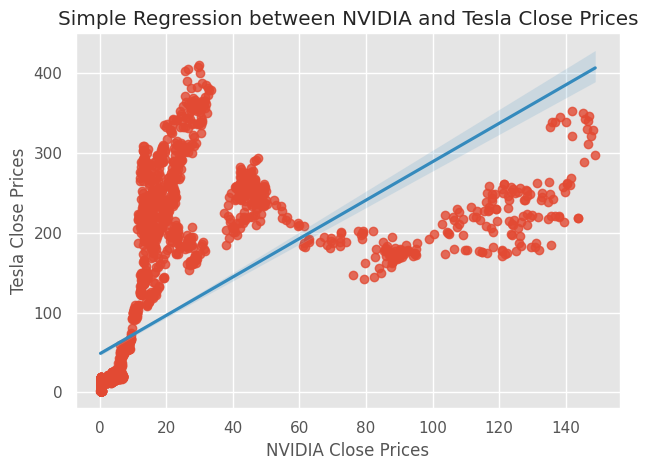

R^2: 0.3870
Coefficient: 2.4070


In [ ]:
time_filter_tsla = tsla.index > datetime(2011,1,1)
time_filter_nvda = nvda.index > datetime(2011,1,1)
time_filter_sp500= sp500.index > datetime(2011,1,1)
tsla_filtered = tsla[time_filter_tsla]
nvda_filtered = nvda[time_filter_nvda]
sp500_filtered = sp500[time_filter_sp500]
nvda_close = nvda_filtered.adjClose
tsla_close = tsla_filtered.adjClose
sp500_close = sp500_filtered.adjClose

plt.style.use('ggplot')

sns.regplot(x=nvda_close, y=tsla_close, line_kws={"color": "C1"})
plt.xlabel('NVIDIA Close Prices')
plt.ylabel('Tesla Close Prices')
plt.title("Simple Regression between NVIDIA and Tesla Close Prices")
plt.tight_layout()
plt.savefig('linear_regression.png')
plt.show()

x = nvda_close.values.reshape(-1, 1)
y = tsla_close.values
model = LinearRegression()
model.fit(x, y)
r_squared = model.score(x, y)
coefficient = model.coef_[0]
print(f"R^2: {r_squared:.4f}")
print(f"Coefficient: {coefficient:.4f}")

From this graph, we could see from the scatter that there is a non linear regresion among NVIDIA and Tesla adjusted close prices. The linear regression could not fit the model very well.  
We try to use polynomial regression to fit the relation between NVIDIA and Tesla relationship.

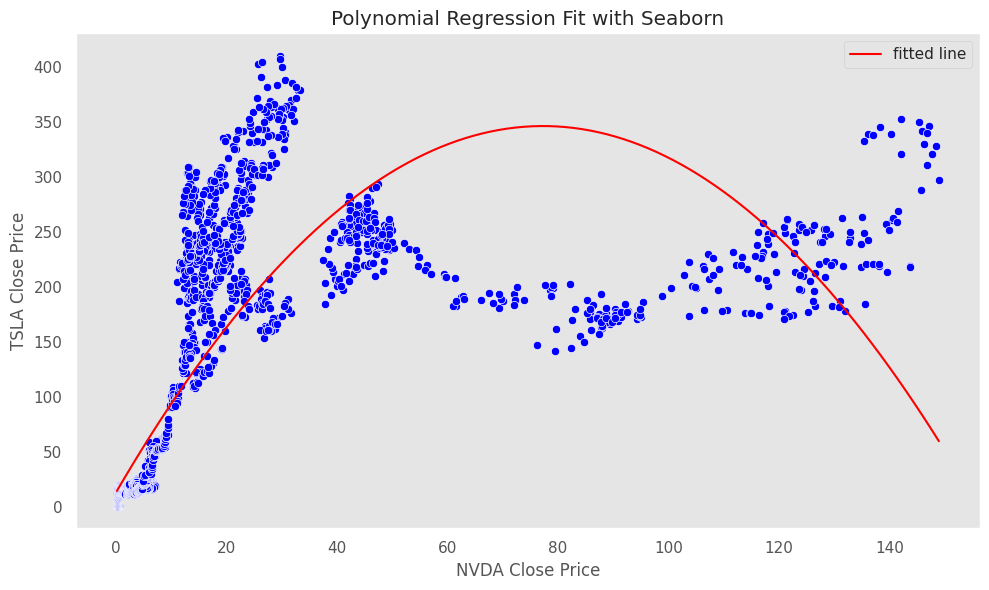

Intercept: 12.65443769212537
Coefficients: [ 0.          8.63134623 -0.05583802]
R^2 Score: 0.693271929034194


In [ ]:
x = nvda_close.to_numpy().reshape(-1,1)
y = tsla_close.to_numpy()

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)
predictions = pd.DataFrame({'NVDA Close': x_range.flatten(), 'Predicted TSLA Close': y_pred})

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nvda_close, y=tsla_close, color='blue')
sns.lineplot(data=predictions, x='NVDA Close', y='Predicted TSLA Close', color='red', label='fitted line')


plt.xlabel('NVDA Close Price')
plt.ylabel('TSLA Close Price')
plt.title('Polynomial Regression Fit with Seaborn')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('polynomial_regression.png')
plt.show()


print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


r2 = model.score(x_poly, y)
print("R^2 Score:", r2)


## Volatility

In [ ]:
def volatilityCalculator(adjustedClosedPrice):

    WEEKLY = 5 # Trading day per week for calculating weekly volatility
    MONTH = 21  #Trading day per month for calculating month volatility
    QUARTER = 63 #Trading day per quater for calculating quater volatility
    ANNUAL = 252 #Trading day per year for calculating annual volatility

    adjustedClosedPrice = adjustedClosedPrice.sort_index()
    adjustedClosedPriceRatio = adjustedClosedPrice / adjustedClosedPrice.shift(1)
    adjustedClosedPriceRatio = adjustedClosedPriceRatio.fillna(0)
    adjustedClosedPriceRatio = np.log(adjustedClosedPriceRatio)

    result = {
        'Weekly Volatility': adjustedClosedPriceRatio.rolling(window=WEEKLY).std() * np.sqrt(WEEKLY),
        'Monthly Volatility': adjustedClosedPriceRatio.rolling(window=MONTH).std() * np.sqrt(MONTH),
        'Quarterly Volatility': adjustedClosedPriceRatio.rolling(window=QUARTER).std() * np.sqrt(QUARTER),
        'Annual Volatility': adjustedClosedPriceRatio.rolling(window=ANNUAL).std() * np.sqrt(ANNUAL)
    }

    volatility_df = pd.DataFrame(result)
    return volatility_df


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


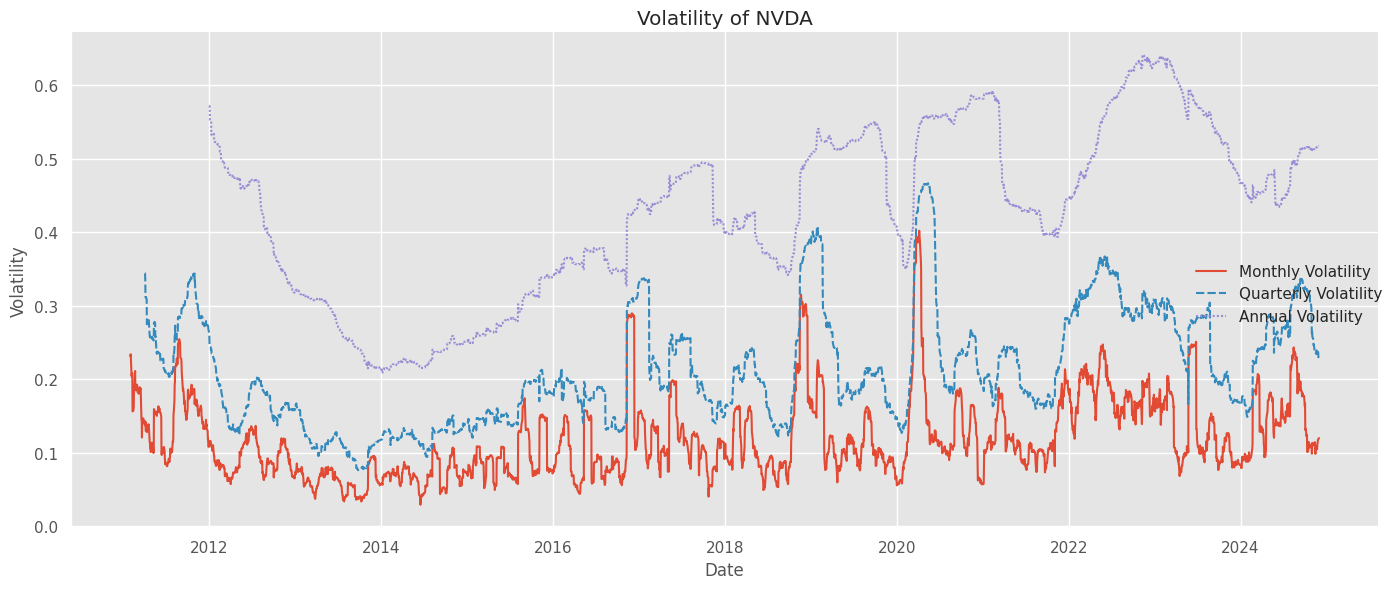

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


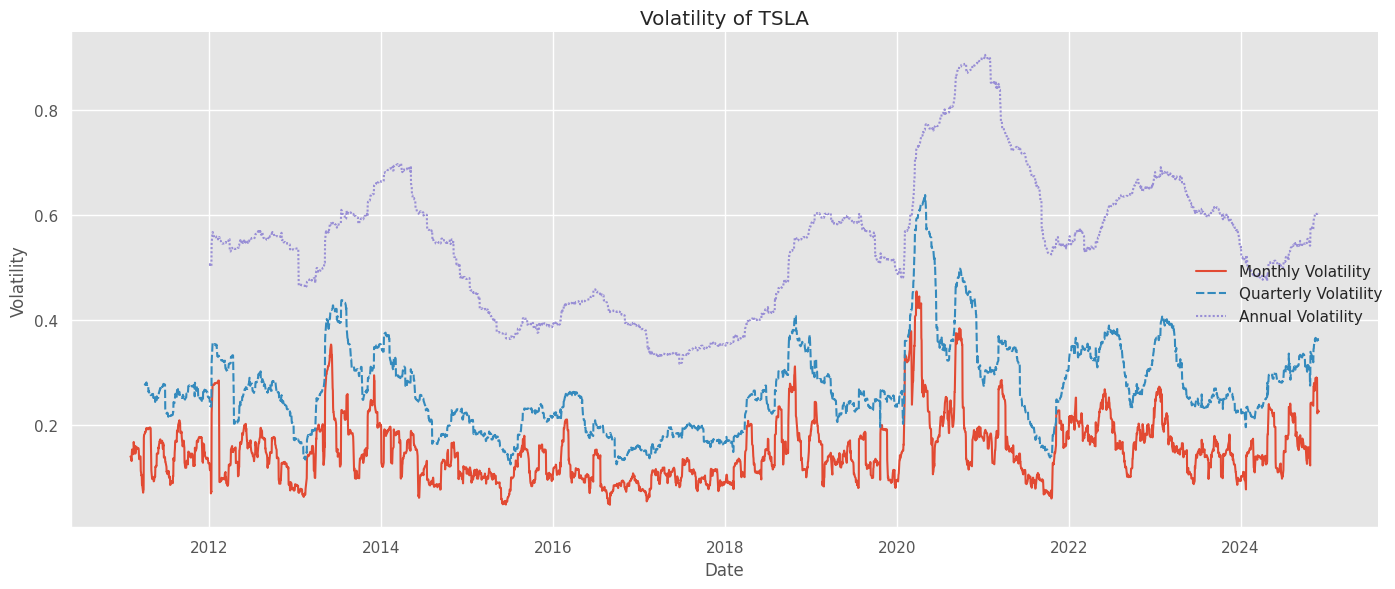

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


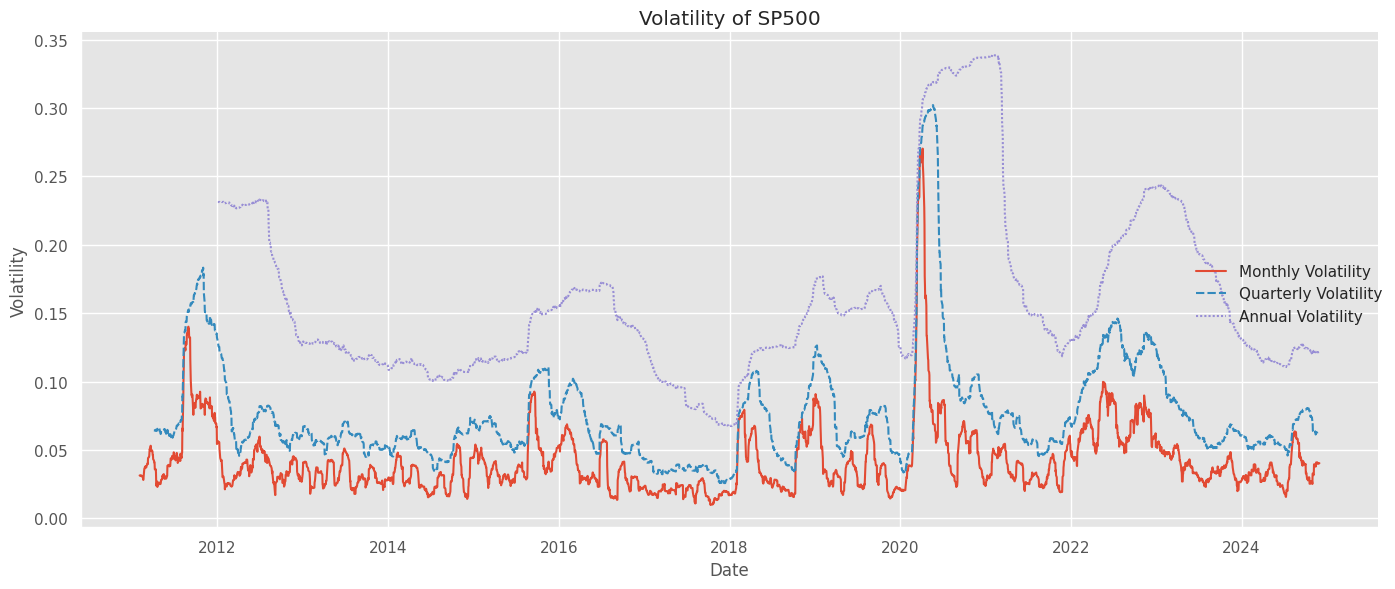

In [ ]:
nvda_volatility = volatilityCalculator(nvda_close)
graph = sns.relplot(data = nvda_volatility[['Monthly Volatility', 'Quarterly Volatility', 'Annual Volatility']]
, kind="line", height=6, aspect = 2)
plt.title('Volatility of NVDA')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.savefig('nvda_volatility.png')
plt.show()

tsla_volatility = volatilityCalculator(tsla_close)
graph = sns.relplot(data = tsla_volatility[['Monthly Volatility', 'Quarterly Volatility', 'Annual Volatility']]
, kind="line", height=6, aspect = 2)
plt.title('Volatility of TSLA')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.savefig('tsla_volatility.png')
plt.show()

sp500_volatility = volatilityCalculator(sp500_close)
graph = sns.relplot(data = sp500_volatility[['Monthly Volatility', 'Quarterly Volatility', 'Annual Volatility']]
, kind="line", height=6, aspect = 2)
plt.title('Volatility of SP500')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.tight_layout()
plt.grid(True)
plt.savefig('sp500_volatility.png')
plt.show()



## Moving average

In [ ]:
class MovingAverage():
    def __init__(self,adjustedClosedPrice, window):
        self.data = adjustedClosedPrice
        self.window = window
        self.predict = pd.DataFrame(index=self.data.index)
    def calculate(self):
        if len(self.window ) > 1:
            for i in self.window :
                self.predict[f'MA_{i}']  = self.data.rolling(window=i).mean()
        else:
            self.predict[f'MA_{self.window[0]}'] = self.data.rolling(window=self.window[0]).mean()
    def plot(self):
        plt.figure(figsize=(15, 10))
        colors = sns.color_palette("tab10", n_colors=len(self.predict.columns)+1)
        sns.lineplot(data = self.data, label='Original Data', alpha=0.7,color = colors[0])
        idx = 1
        for i in self.predict.columns:
            sns.lineplot(data = self.predict[i], label=f'Moving Average {i.split("_")[1]} Days',color = colors[idx])
            idx = idx+1
        plt.title(f'Moving Average')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show()

        idx = 1
        for i in self.predict.columns:
            sns.relplot(data = self.predict[i], label=f'Moving Average {i.split("_")[1]} Days',color = colors[idx],kind="line",height=3, aspect = 5)
            idx = idx+1
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()



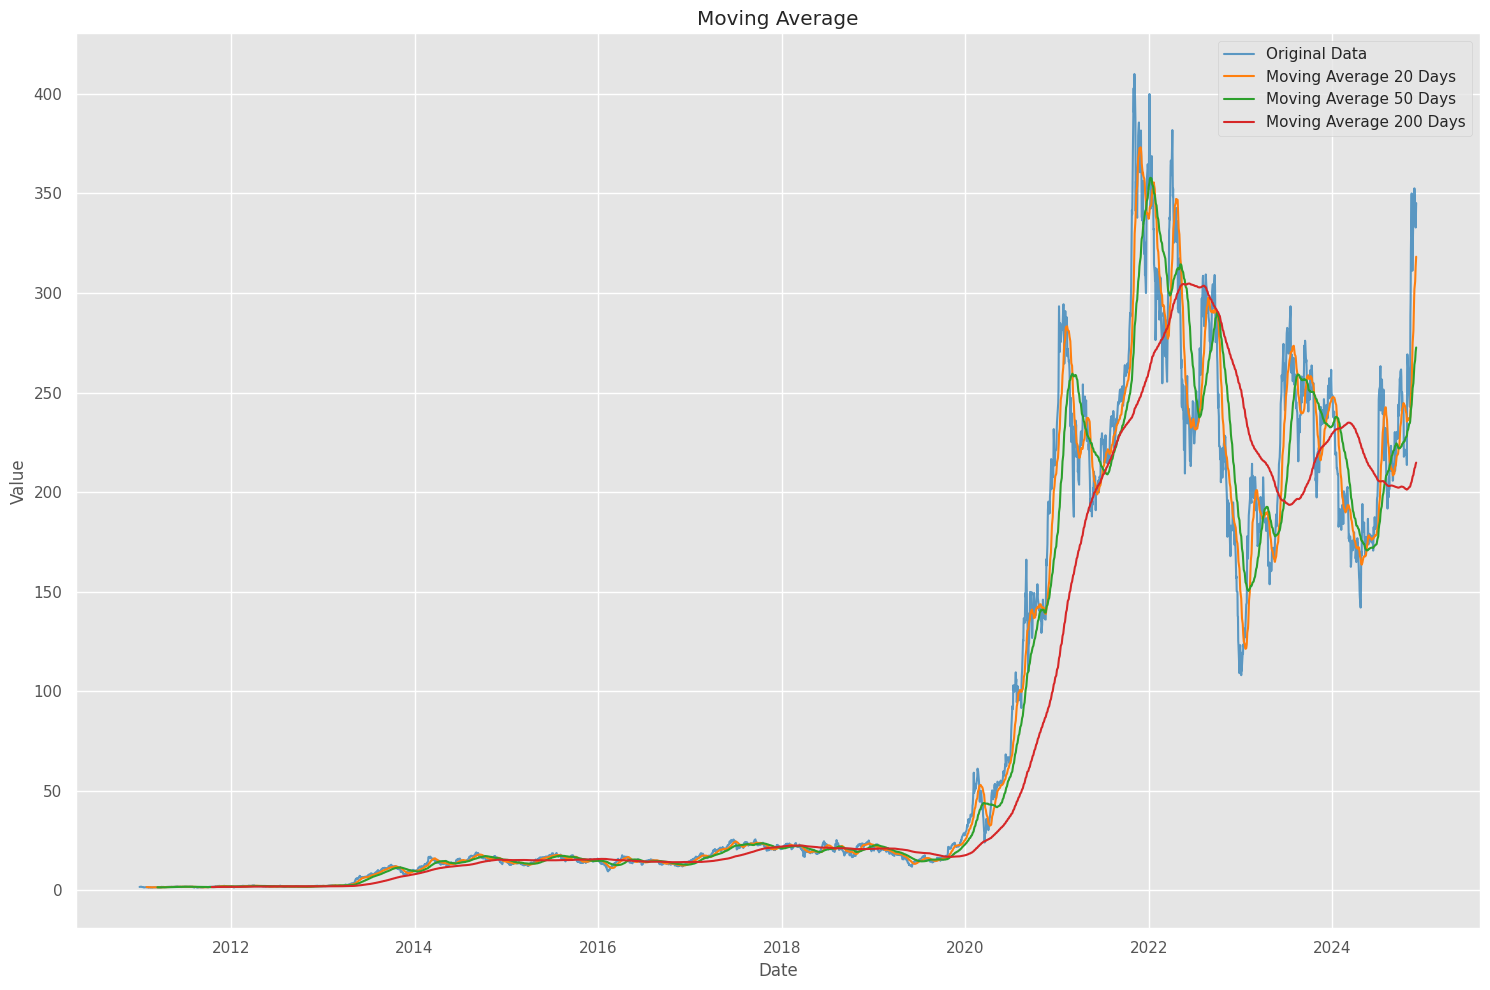

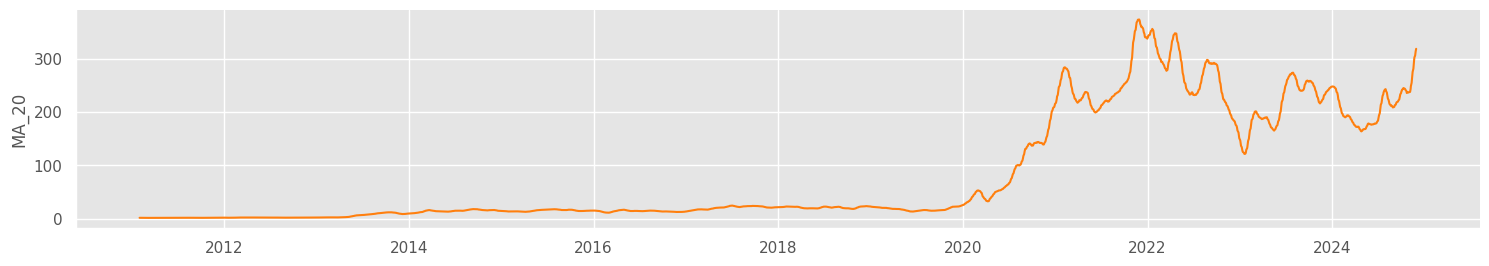

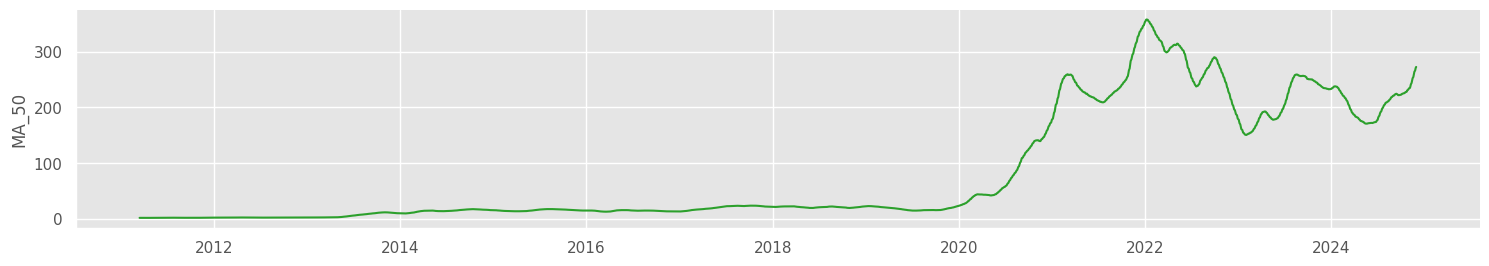

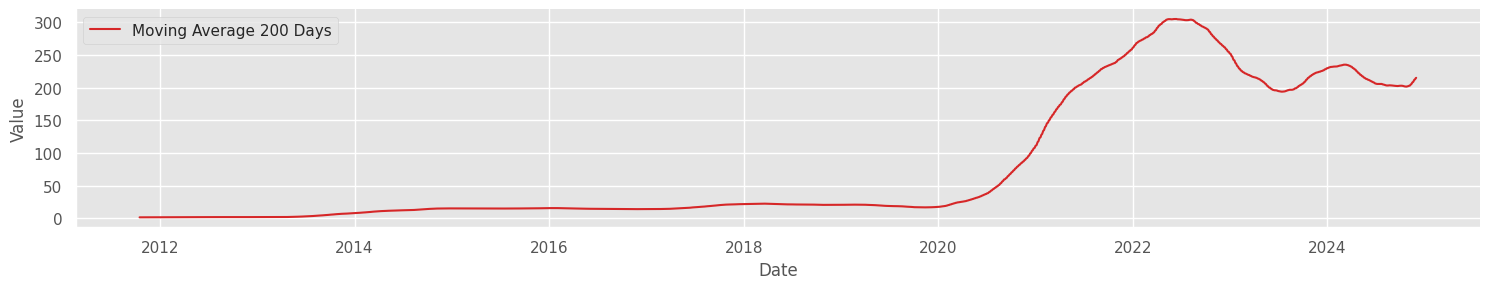

In [ ]:
tsla_MA = MovingAverage(tsla_close, [20,50,200])
tsla_MA.calculate()
tsla_MA.plot()

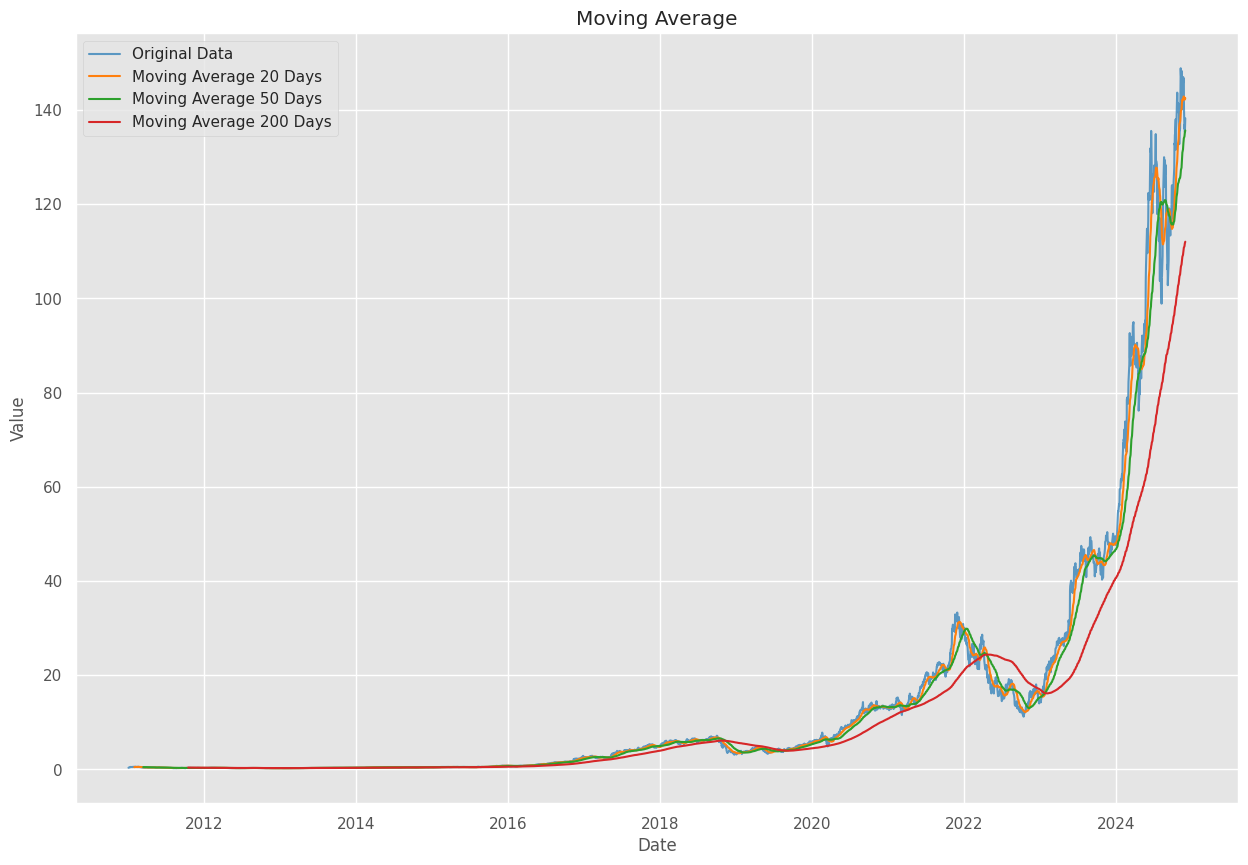

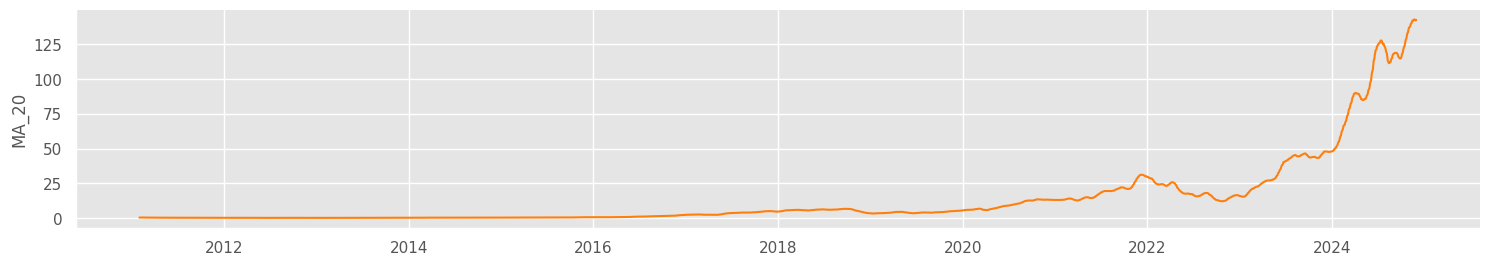

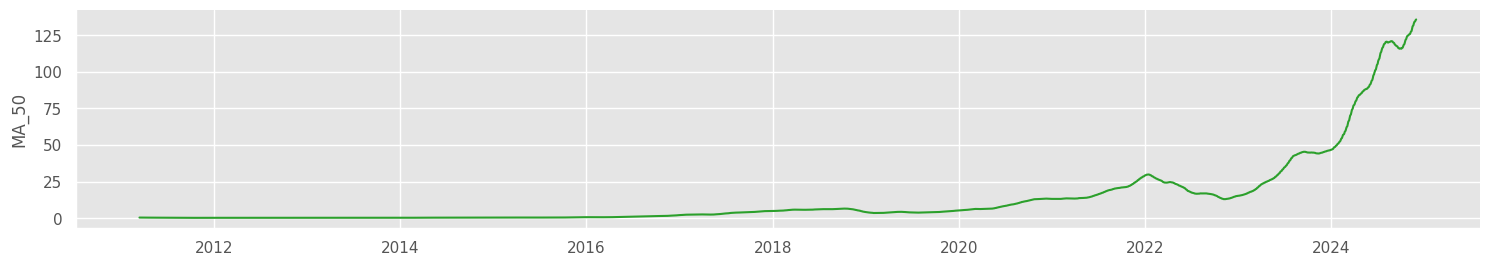

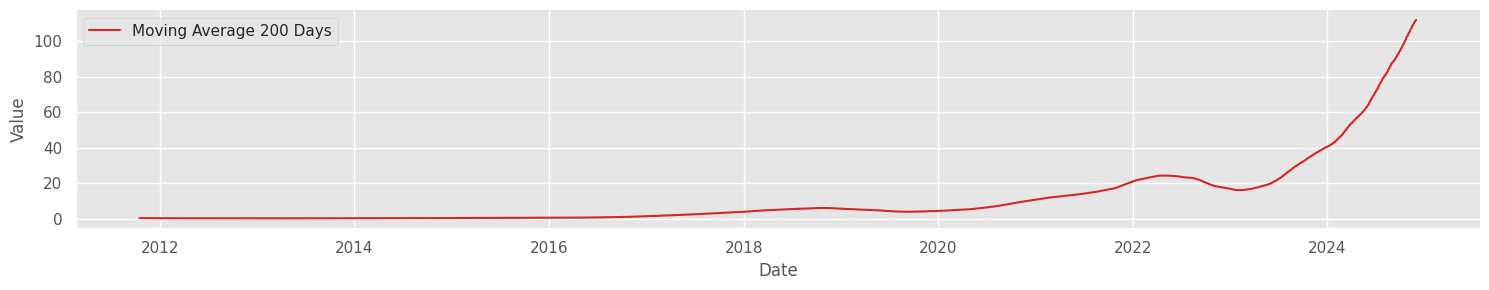

In [ ]:
nvda_MA = MovingAverage(nvda_close, [20,50,200])
nvda_MA.calculate()
nvda_MA.plot()

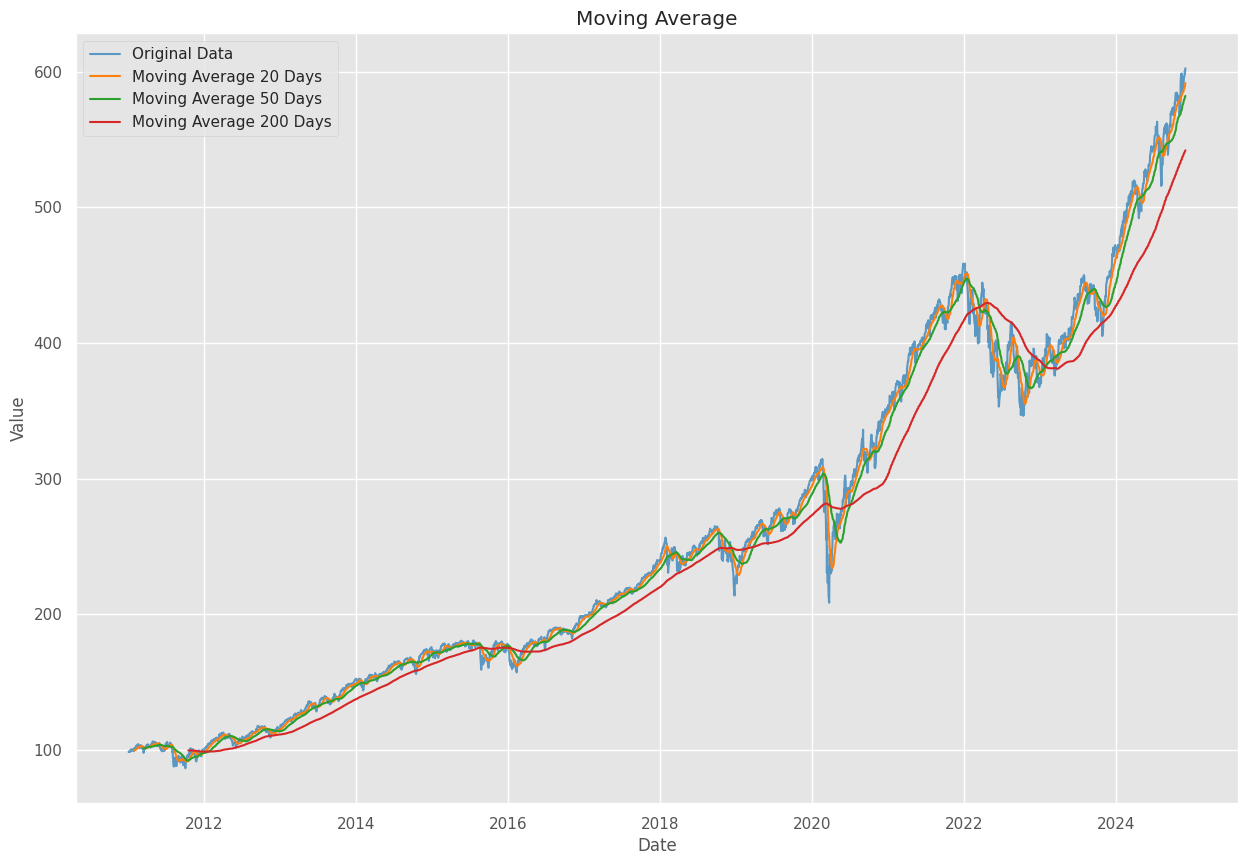

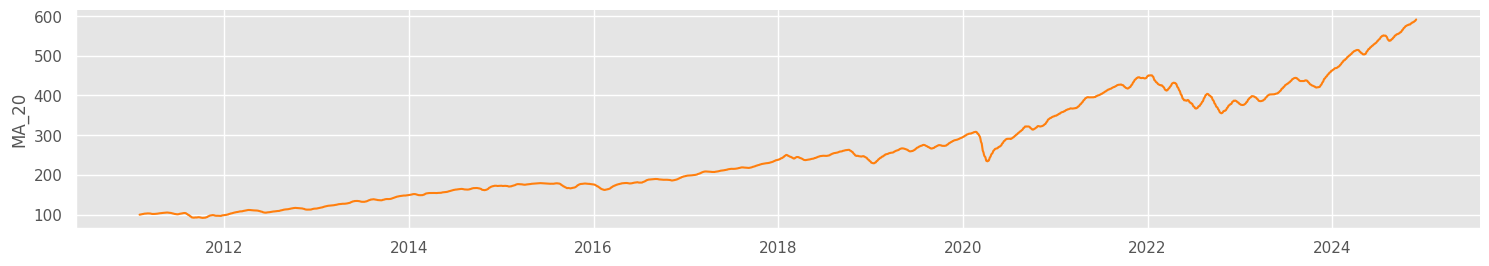

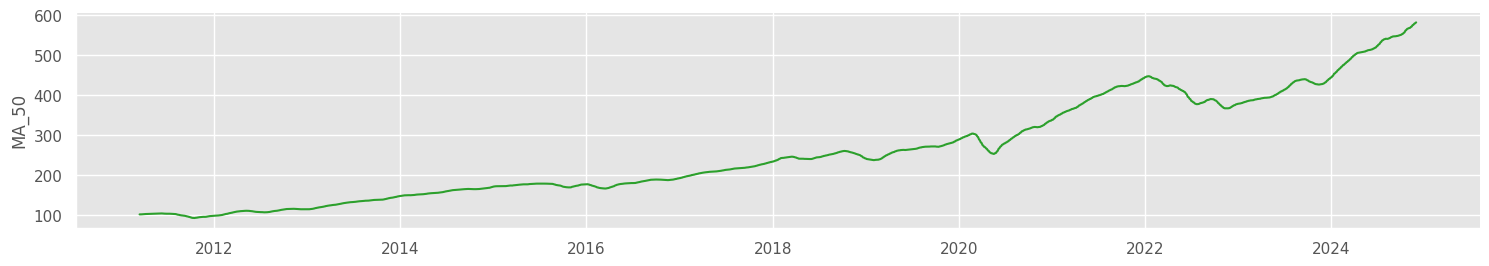

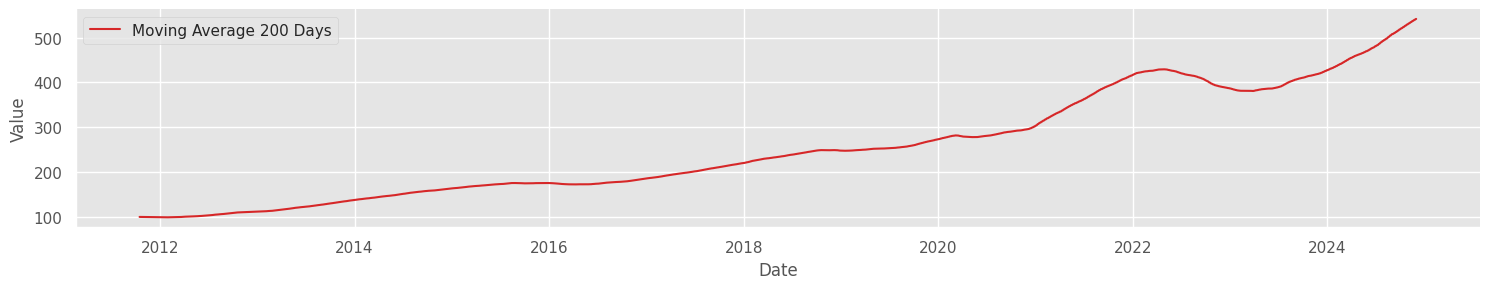

In [ ]:
sp500_MA = MovingAverage(sp500_close, [20,50,200])
sp500_MA.calculate()
sp500_MA.plot()

##Relations with Interest Rate and Income Level


We retrieve interest rate data from FRED for the period between January 1, 2011, and December 1, 2024, and see the trend of interest rate from 2011 to 2024.
And we visualize interest rate with NVDA close price, interest rate with TSLA close price, and interest rate with SP500 close price in 3 graphs, to see the relations between them. As the values and units of the 2 variables are very different (interest rate percentage is lower than 5, while close price is normally higher than 10), to better see the changes and trends, we use dual and different y-axes, so the trends of both variables can be observed on the same timeline.

In [ ]:
start = '2011-01-01'
end = '2024-12-01'
Interest_rate = pdr.DataReader('DGS10', 'fred', start, end)

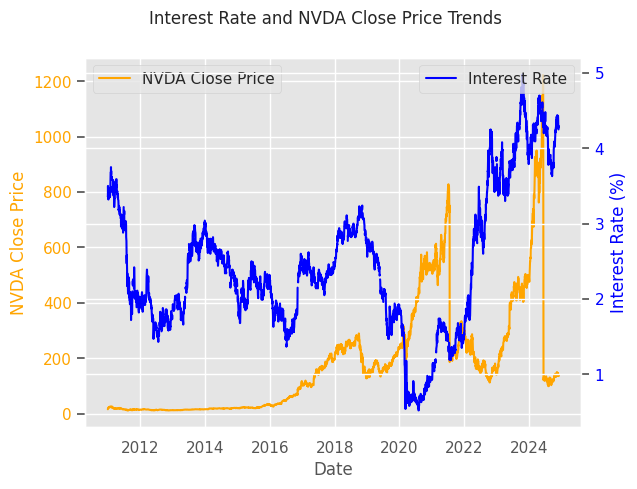

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(nvda['2011':'2024']['close'], color='orange', label='NVDA Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('NVDA Close Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(Interest_rate["DGS10"], color='blue', label='Interest Rate')
ax2.set_ylabel('Interest Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle('Interest Rate and NVDA Close Price Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

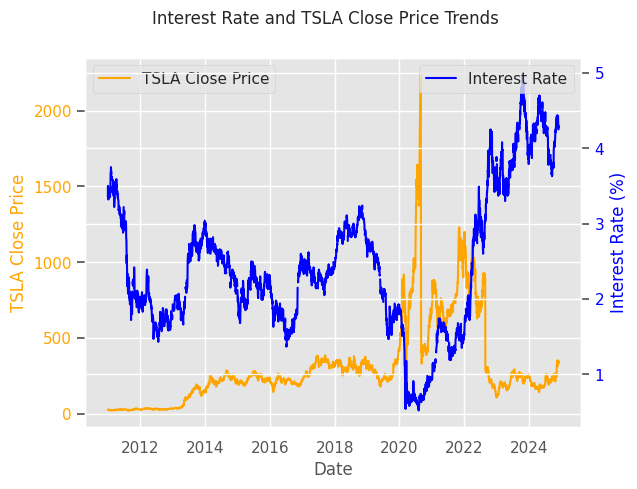

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(tsla['2011':'2024']['close'], color='orange', label='TSLA Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('TSLA Close Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(Interest_rate["DGS10"], color='blue', label='Interest Rate')
ax2.set_ylabel('Interest Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle('Interest Rate and TSLA Close Price Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

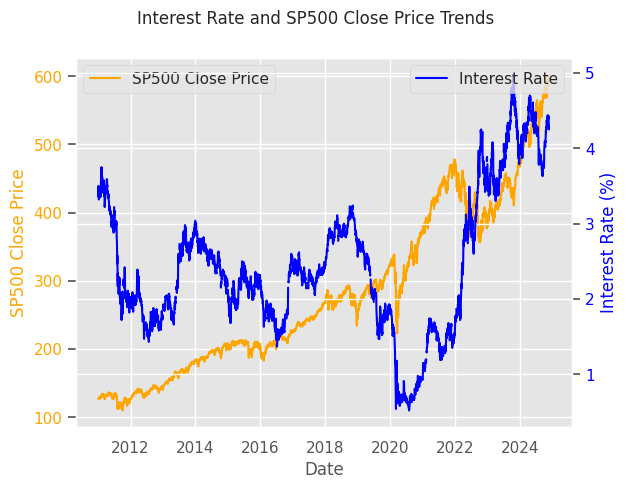

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(sp500['2011':'2024']['close'], color='orange', label='SP500 Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('SP500 Close Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(Interest_rate["DGS10"], color='blue', label='Interest Rate')
ax2.set_ylabel('Interest Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle('Interest Rate and SP500 Close Price Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

From the above 3 graphs, we can see that for all these 3 stocks and index, when there is a significant decrease in interest rate (in blue), stocks’ and index’s close price (in orange) will go up.

We retrieve income level data from FRED for the period between January 1, 2011, and December 1, 2024 (same as interest rate timeline), and see the trend of income level from 2011 to 2024.
And we visualize income level with NVDA close price, income level with TSLA close price, and income level with SP500 close price in 3 graphs, to see the relations between them. By using dual and different y-axes, the trends of both variables can be observed on the same timeline.

<Axes: title={'center': 'Income level'}, xlabel='DATE'>

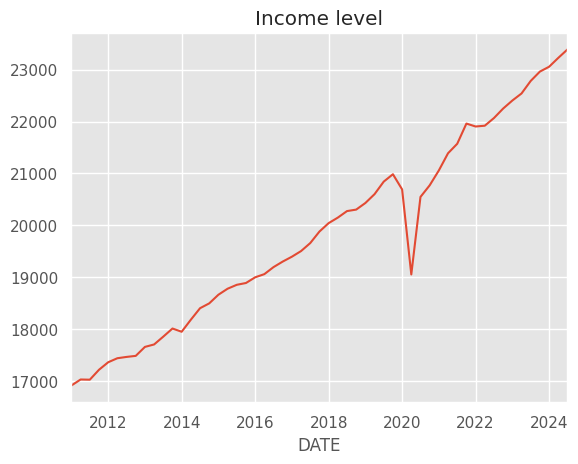

In [ ]:
Income_level = pdr.DataReader('GDPC1', 'fred', start, end)
Income_level["GDPC1"].plot(title='Income level')

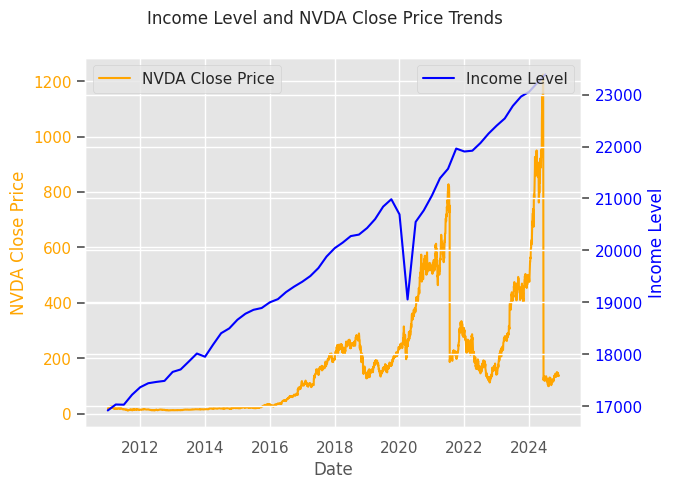

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(nvda['2011':'2024']['close'], color='orange', label='NVDA Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('NVDA Close Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(Income_level["GDPC1"], color='blue', label='Income Level')
ax2.set_ylabel('Income Level', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle('Income Level and NVDA Close Price Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

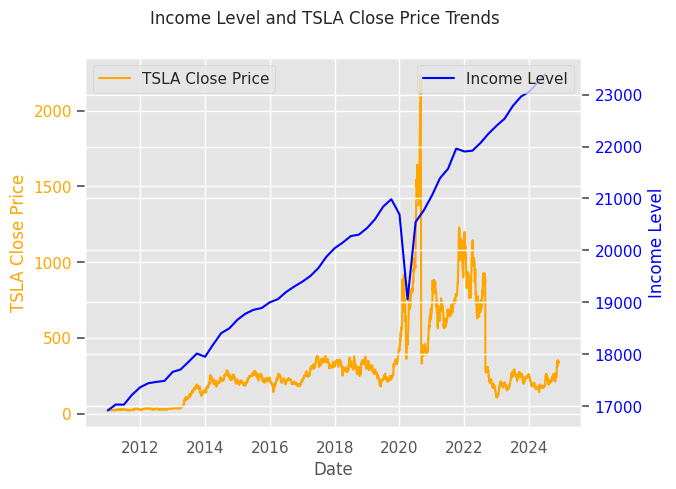

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(tsla['2011':'2024']['close'], color='orange', label='TSLA Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('TSLA Close Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(Income_level["GDPC1"], color='blue', label='Income Level')
ax2.set_ylabel('Income Level', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle('Income Level and TSLA Close Price Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

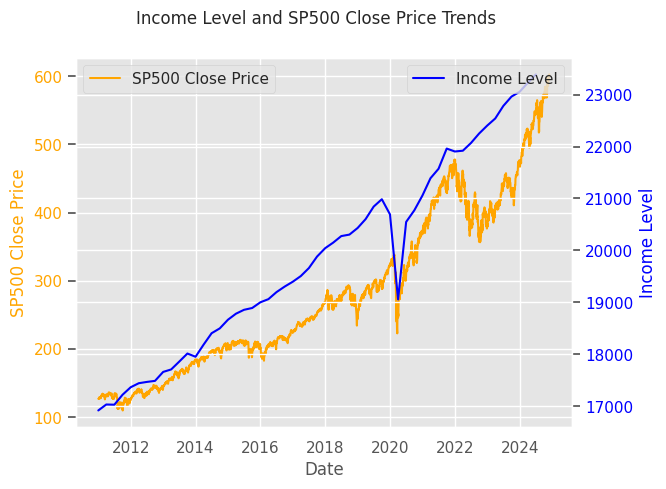

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(sp500['2011':'2024']['close'], color='orange', label='SP500 Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('SP500 Close Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(Income_level["GDPC1"], color='blue', label='Income Level')
ax2.set_ylabel('Income Level', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle('Income Level and SP500 Close Price Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

When there is a significant decrease in income level, the stocks's and index's prices also experience a drop.
Particularly the SP500, its price has a very similar trend as the income level does over time, as we can see in the last graph.

# Prediction